In [1]:
import os
import pickle
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [2]:
BASE_DIR = 'Data'
WORKING_DIR = 'Transfer'
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [3]:
from tqdm import tqdm
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

features = {}

directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory), desc="Extracting features"):
    
    img_path = os.path.join(directory, img_name)
    
    image = load_img(img_path, target_size=(224, 224))
    
    image = img_to_array(image)
    
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    image = preprocess_input(image)
    
   
    feature = model.predict(image, verbose=0)
    
    image_id = img_name.split('.')[0]
    
    features[image_id] = feature

pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))


Extracting features: 100%|██████████| 8091/8091 [32:30<00:00,  4.15it/s]


In [4]:
import os
import pickle

with open(os.path.join('Transfer', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)
with open(os.path.join('Data', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()
from tqdm.notebook import tqdm

mapping = {}

for line in tqdm(captions_doc.split('\n')):
 
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
  
    image_id = image_id.split('.')[0]
  
    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []
   
    mapping[image_id].append(caption)
len(mapping)


  0%|          | 0/40455 [00:00<?, ?it/s]

8091

In [5]:
import re
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
       
            caption = captions[i]
        
            caption = caption.lower()
   
            caption = caption.replace('[^A-Za-z]', '')
     
            caption = re.sub(r'\s+', ' ', caption)
     
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption
mapping['1000268201_693b08cb0e']
clean(mapping)



In [6]:
mapping['1000268201_693b08cb0e']
all_captions = []


In [7]:
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)
all_captions[:10]
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
with open('Transfer/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

max_length = max(len(caption.split()) for caption in all_captions)
max_length
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]



In [8]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
 
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
    
            for caption in captions:
    
                seq = tokenizer.texts_to_sequences([caption])[0]
         
                for i in range(1, len(seq)):
              
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
              
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                  
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0


In [9]:
from keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from keras.models import Model
from tensorflow.keras.utils import plot_model


inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

try:
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    print("Model plot saved to 'model_plot.png'")
except Exception as e:
    print(f"Error plotting the model: {e}")



Error plotting the model: module 'pydot' has no attribute 'InvocationException'


In [10]:
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
 
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
import pickle


with open('Transfer/best_model.pkl', 'wb') as file:
    pickle.dump(model, file)



227/227 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - loss: 5.7787
227/227 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - loss: 4.0822
227/227 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - loss: 3.5961
227/227 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - loss: 3.3149
227/227 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - loss: 3.1152
227/227 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - loss: 2.9652
227/227 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - loss: 2.8440
227/227 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 2.7480
227/227 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - loss: 2.6657
227/227 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - loss: 2.6026
227/227 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - loss: 2.5351
227/227 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - loss: 2.4707
227/227 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - loss: 2.4185
227/227 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - loss: 2.3718
227/227 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - loss: 2.3266
227/227 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - loss: 2.2853
227/227 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - loss: 2.2513
227/227 ━━━━━━━━━━━━━━━━━━━━ 36

In [11]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def predict_caption(model, image, tokenizer, max_length):
    
    in_text = 'startseq'
 
    for i in range(max_length):
   
        sequence = tokenizer.texts_to_sequences([in_text])[0]
  
        sequence = pad_sequences([sequence], max_length, padding='post')
 
        yhat = model.predict([image, sequence], verbose=0)

        yhat = np.argmax(yhat)

        word = idx_to_word(yhat, tokenizer)

        if word is None:
            break
       
        in_text += " " + word
    
        if word == 'endseq':
            break
    return in_text


In [12]:
from nltk.translate.bleu_score import corpus_bleu
# validate 
actual, predicted = list(), list()

for key in tqdm(test):
   
    captions = mapping[key]
  
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
 
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

c:\Users\pushk\AppData\Local\Programs\Python\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\pushk\AppData\Local\Programs\Python\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.500000
BLEU-2: 0.213201
BLEU-1: 0.523810
BLEU-2: 0.287588
BLEU-1: 0.451613
BLEU-2: 0.254000
BLEU-1: 0.476190
BLEU-2: 0.250313
BLEU-1: 0.456140
BLEU-2: 0.229416
BLEU-1: 0.408451
BLEU-2: 0.194173
BLEU-1: 0.415584
BLEU-2: 0.188737
BLEU-1: 0.436782
BLEU-2: 0.223069
BLEU-1: 0.436170
BLEU-2: 0.214902
BLEU-1: 0.490741
BLEU-2: 0.283056
BLEU-1: 0.512821
BLEU-2: 0.303184
BLEU-1: 0.530769
BLEU-2: 0.307342
BLEU-1: 0.539568
BLEU-2: 0.313835
BLEU-1: 0.509554
BLEU-2: 0.286280
BLEU-1: 0.524390
BLEU-2: 0.296623
BLEU-1: 0.514124
BLEU-2: 0.293632
BLEU-1: 0.529101
BLEU-2: 0.293484
BLEU-1: 0.524752
BLEU-2: 0.297337
BLEU-1: 0.530516
BLEU-2: 0.300404
BLEU-1: 0.540541
BLEU-2: 0.314658
BLEU-1: 0.545455
BLEU-2: 0.314168
BLEU-1: 0.550000
BLEU-2: 0.317675
BLEU-1: 0.558233
BLEU-2: 0.329670
BLEU-1: 0.558594
BLEU-2: 0.325485
BLEU-1: 0.562264
BLEU-2: 0.331828
BLEU-1: 0.575092
BLEU-2: 0.347954
BLEU-1: 0.567376
BLEU-2: 0.340147
BLEU-1: 0.563574
BLEU-2: 0.337004
BLEU-1: 0.556291
BLEU-2: 0.328630
BLEU-1: 0.5523

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    
    image_id = image_name.split('.')[0]
    img_path = os.path.join('Data', "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
   
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)



---------------------Actual---------------------
startseq brown and black dog is jumping through sprinkler endseq
startseq dog playing with sprinkler endseq
startseq german shepherd runs through sprinkler endseq
startseq tan and black dog jumps through water sprinkler in the yard endseq
startseq the german shepherd dog is jumping up as it is being squirted with jet of water endseq
--------------------Predicted--------------------
startseq dog is walking through sprinkler endseq


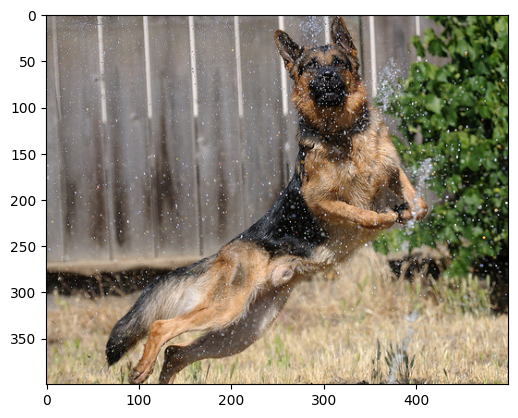

In [21]:
generate_caption('3725353555_75c346d7ec.jpg')